# KTモデルを使ってFMI/FMUで遊ぼう

## このNotebookの動作環境について

- JModelicaを利用してFMUを作成し、作成したFMUを使ってJupyterNotebook上でCo-simulationを実行するサンプルです

- ここでは、DockerHubにある[taiga4112/jmodelica:jm0](https://hub.docker.com/repository/docker/taiga4112/jmodelica)のイメージを利用して以下のコマンドでJupyterを起動し、起動したJupyter上でこのノートブックを動作させることを想定している
    - [taiga4112/jmodelica:jm0](https://hub.docker.com/repository/docker/taiga4112/jmodelica)は、この[ページ](https://www.amane.to/archives/710)に従ってContainer Imageを作成してPushしたもの
        - 本当はJModelicaに登録しないといけないっぽいので、あくまで私的利用のためにお使いください（はーと）

```sh
$ docker pull taiga4112/jmodelica:jm0
$ docker run -it --name ktjm -p 8888:8888 \
    -u root -v $(pwd)/notebooks:/home/jmodelica/jmodelica \
    taiga4112/jmodelica:jm0 /usr/local/jmodelica/bin/jm_start.sh
```
    
- コマンド実行後、[http://localhost:8888](http://localhost:8888)にアクセスする
    - Access Tokenは`jmodelica`です

### JModelica

> JModelica.org は、Modelica 言語に基づいて複雑な動的システムのモデル化、シミュレーション、最適化および分析などを行うプラットフォームとなるソフトウェアです。モデルは Modelica 言語で記述しますが、オペレーションのほとんどは Python を使用して行います。Lund 大学などの学術機関と民間企業の協力を得て、Modelon AB によってオープンソースソフトウェアとして維持開発されてきました。Modelon は、2019年12月18日に、Assimulo, PyFMI, FMI Library を除くコンパイラや最適化機能など含む部分を一般に使用可能なオープンソースとすることを止めてしまいました。今後も商用および学術的用途で利用されるソフトウェアとして開発は続けられるそうです。
> 
> 現在、https://jmodelica.org/ のフォームに登録することによって、最後のオープンソースバージョンのソースコードと Windows用バイナリのダウンロードが可能です。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymodelica import compile_fmu
from pyfmi import load_fmu
from pyfmi.master import Master
%matplotlib inline

## A. KT_3DOFモデルの作成



- 変数の型はすべてRealでも良いけども、お作法として[Modelica.SIunits](https://www.maplesoft.com/documentation_center/online_manuals/modelica/Modelica_SIunits.html#Modelica.SIunits.Velocity)を使って定義した

In [2]:
%%writefile KT_3DOF.mo
model KT_3DOF
    
    import SI = Modelica.SIunits;

    // Maneuvering Parameters
    parameter Real K = 80.0;
    parameter Real T = 150.0;
    
    // State start values
    parameter SI.Velocity u_0 = 10;
    parameter SI.Velocity v_0 = 0;
    parameter SI.AngularVelocity r_0 = 0;
    
    // The states
    output SI.Velocity u(start = u_0);
    output SI.Velocity v(start = v_0);
    output SI.AngularVelocity r(start = r_0);
    
    // The control signal
    input SI.Angle delta;
    
equation
    der(u) = 0.0;
    der(v) = 0.0;
    der(r) = 1.0 / T * (- r + K * delta);
end KT_3DOF;

Overwriting KT_3DOF.mo


FMI2.0 for Co-Simualtion の規格に従う KT_3DOF モデルの FMUファイル を生成します。

In [3]:
fmu = compile_fmu("KT_3DOF","KT_3DOF.mo", version='2.0', target='cs',compile_to = "KT_3DOF.fmu")

まずはこれだけを動かしてみるっす

###  1. 操作量(舵角)の設定

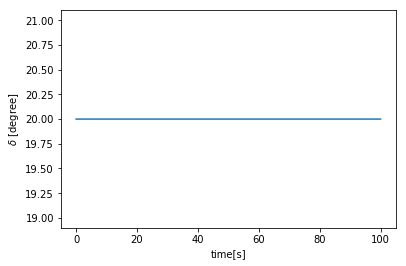

In [4]:
time = np.linspace(0,100,10000)
delta_rad = np.full(10000, np.deg2rad(20))
plt.plot(time, np.rad2deg(delta_rad))
plt.xlabel('time[s]')
plt.ylabel(r'$\delta$ [degree]');

FMUに入力するためのデータ変換

In [5]:
delta_traj = np.transpose(np.vstack((time, delta_rad)))
delta_info =  ('delta', delta_traj)

### 2. FMUファイルの読み込みとシミュレーション実行

In [6]:
# FMUの読み込み
model_kt3dof = load_fmu("KT_3DOF.fmu")
# Parameterの設定
model_kt3dof.set('K', 50)
model_kt3dof.set('T', 70)
# Simulation
result = model_kt3dof.simulate(final_time=100, input=delta_info)

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.0224978923798 seconds.


とりあえず結果確認

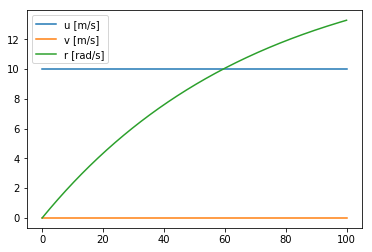

In [7]:
u = result['u']
v = result['v']
r = result['r']
t = result['time']
plt.plot(t, u, t, v, t, r)
plt.legend(('u [m/s]','v [m/s]', 'r [rad/s]'));

## B. KT_3DOFモデルと連動するShipConditionモデルの作成



In [8]:
%%writefile ShipCondition.mo
model ShipCondition

    import SI = Modelica.SIunits;
    
    // State start values
    parameter SI.Position x_0 = 0;
    parameter SI.Position y_0 = 0;
    parameter SI.Angle psi_0 = 0;
    
    // The states
    output SI.Position x(start = x_0);
    output SI.Position y(start = y_0);
    output SI.Angle psi(start = psi_0);
    
    // The control signal
    input SI.Velocity u;
    input SI.Velocity v;
    input SI.AngularVelocity r;
    
equation
    der(x) = u * cos(psi) + v * sin(psi);
    der(y) = u * sin(psi) + v * cos(psi);
    der(psi) = r;
end ShipCondition;

Overwriting ShipCondition.mo


In [9]:
fmu = compile_fmu("ShipCondition","ShipCondition.mo", version='2.0', target='cs',compile_to = "ShipCondition.fmu")

Co-Simulationってやつをやってみる

In [10]:
model_kt3dof = load_fmu("KT_3DOF.fmu")
model_shipcondition = load_fmu("ShipCondition.fmu")
models = [model_kt3dof, model_shipcondition]
connections = [
    (model_kt3dof, "u", model_shipcondition,"u"), 
    (model_kt3dof, "v", model_shipcondition,"v"), 
    (model_kt3dof, "r", model_shipcondition,"r")
]
coupled_simulation = Master(models, connections)

In [11]:
t_start = 0.0
t_end = 10.0
dt = (t_end - t_start)/1000
opts = coupled_simulation.simulate_options()
opts["step_size"] = dt
opts["linear_correction"] = False

# inputシグナルはlambda型の関数で作らないとだめっぽい
delta_rad_func = lambda time: np.deg2rad(20)

res = coupled_simulation.simulate(start_time = t_start, final_time = t_end, options = opts, input=((model_kt3dof, "delta"), delta_rad_func))

Elapsed initialization time: 0.000423192977905 seconds.
Master Algorithm options:
 Algorithm             : Jacobi (fixed-step)
  Execution            : Serial
 Extrapolation Order   : 0
 Step-size             : 0.01
 Algebraic loop        : False
  Linear Correction    : False

Statistics: 
 Number of global steps        : 1000

Simulation interval      : 0.0 - 10.0 seconds.
Elapsed simulation time  : 0.19367814064 seconds.
 0.007419 seconds spent in KT_3DOF.
 0.021675 seconds spent in ShipCondition.
 0.092628 seconds spent saving simulation result.


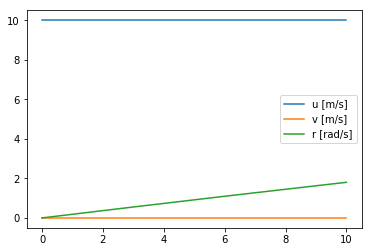

In [12]:
u = res[model_kt3dof]['u']
v = res[model_kt3dof]['v']
r = res[model_kt3dof]['r']
t = res[model_kt3dof]['time']
plt.plot(t, u, t, v, t, r)
plt.legend(('u [m/s]','v [m/s]', 'r [rad/s]'));

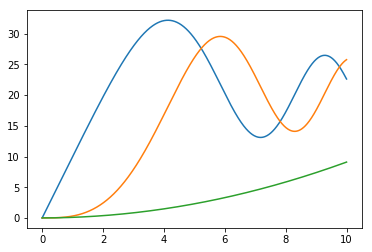

In [13]:
x = res[model_shipcondition]['x']
y = res[model_shipcondition]['y']
psi = res[model_shipcondition]['psi']
t = res[model_shipcondition]['time']
plt.plot(t, x, t, y, t, psi);

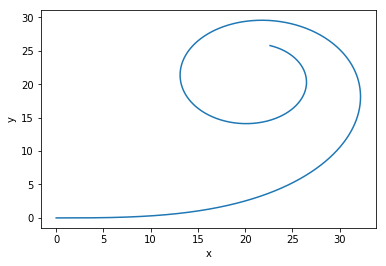

In [14]:
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y');

## C. Rudder Controlモジュールの導入
- 今回はZ試験を実現するRudder Controlモジュールを導入してみた



In [15]:
%%writefile Momoclo_Z.mo
model Momoclo_Z
    
    import SI = Modelica.SIunits;
    import Modelica.SIunits.Conversions.*;
    
    // State start values
    parameter SI.Angle delta_0 = from_deg(10);
    
    // Setting param
    parameter Real psi_min = from_deg(-20);
    parameter Real psi_max = from_deg(+20);
    
    // The states
    output SI.Angle delta(start = delta_0);
    
    // The control signal
    input SI.Angle psi;
    
equation
    
    when psi >= psi_max then
        delta = from_deg(-10);
    elsewhen psi <= psi_min then
        delta = from_deg(10);
    end when;
        
end Momoclo_Z;

Overwriting Momoclo_Z.mo


In [16]:
fmu = compile_fmu("Momoclo_Z","Momoclo_Z.mo", version='2.0', target='cs',compile_to = "Momoclo_Z.fmu")

In [17]:
model_kt3dof = load_fmu("KT_3DOF.fmu")
model_shipcondition = load_fmu("ShipCondition.fmu")
model_ruddercontrol = load_fmu("Momoclo_Z.fmu")
models = [model_kt3dof, model_shipcondition, model_ruddercontrol]
connections = [
    (model_kt3dof, "u", model_shipcondition,"u"), 
    (model_kt3dof, "v", model_shipcondition,"v"), 
    (model_kt3dof, "r", model_shipcondition,"r"),
    (model_shipcondition, "psi", model_ruddercontrol, "psi"),
    (model_ruddercontrol, "delta", model_kt3dof, "delta")
]
coupled_simulation = Master(models, connections)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The model, KT_3DOF, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The model, ShipCondition, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The model, Momoclo_Z, does not support directional derivatives which is necessary in-case of an algebraic loop. The simulation might become unstable...
  if sys.path[0] == '':


In [18]:
t_start = 0.0
t_end = 50.0
dt = (t_end - t_start)/1000
opts = coupled_simulation.simulate_options()
opts["step_size"] = dt
opts["linear_correction"] = False

res = coupled_simulation.simulate(start_time = t_start, final_time = t_end, options = opts)

Elapsed initialization time: 0.00131511688232 seconds.
Master Algorithm options:
 Algorithm             : Jacobi (fixed-step)
  Execution            : Serial
 Extrapolation Order   : 0
 Step-size             : 0.05
 Algebraic loop        : True
  Linear Correction    : False

Statistics: 
 Number of global steps        : 1000

Simulation interval      : 0.0 - 50.0 seconds.
Elapsed simulation time  : 0.232872009277 seconds.
 0.007948 seconds spent in KT_3DOF.
 0.024063 seconds spent in ShipCondition.
 0.010518 seconds spent in Momoclo_Z.
 0.134913 seconds spent saving simulation result.


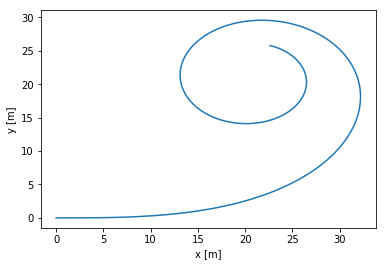

In [19]:
plt.plot(x, y)
plt.xlabel('x [m]')
plt.ylabel('y [m]');

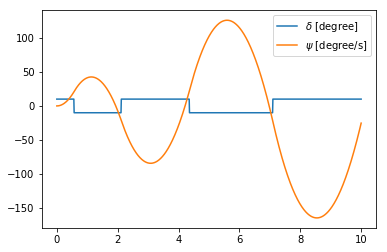

In [20]:
delta = np.rad2deg(res[model_ruddercontrol]['delta'])
psi = np.rad2deg(res[model_ruddercontrol]['psi'])
plt.plot(t, delta, label=r'$\delta$ [degree]')
plt.plot(t, psi, label=r'$\psi$ [degree/s]')
plt.legend();